1. Imports e Configurações

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from pathlib import Path

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)


2. Carregamento e Exploração Inicial dos Dados

In [3]:
BASE_DIR = Path.cwd().parents[2]
DATA_DIR = BASE_DIR / "datalake" / "data-for-model"

cassette_file = DATA_DIR / "sleep-cassette.parquet"
df_cassette = pd.read_parquet(cassette_file, engine="fastparquet")

print("Shape:", df_cassette.shape)
display(df_cassette.head())

print(df_cassette.info())
print(df_cassette["stage"].value_counts(normalize=True))  # balanceamento da variável alvo
print(df_cassette.describe())  # estatísticas descritivas

Shape: (161141, 31)


,subject_id,night_id,epoch_idx,t0_sec,stage,age,sex,tso_min,EEG_Pz_Oz_beta_relpow_256,EEG_Pz_Oz_delta_relpow_256,...,EOG_rms,EOG_beta_relpow_256,EOG_delta_relpow_256,EOG_sef95_256,EMG_submental_p90_1hz,EMG_submental_rms_1hz,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_alpha_relpow_256,EOG_theta_relpow_256,EMG_submental_median_1hz
0,SC400,N1,991,29730.0,W,33,F,0.0,0.282421,0.434532,...,80.893494,0.099188,0.824096,21.875000,3.3808,3.337952,0.030899,0.015324,0.037745,3.329
1,SC400,N1,992,29760.0,W,33,F,0.0,0.257110,0.432998,...,92.922546,0.094244,0.811323,24.218750,3.4768,3.397615,0.023414,0.014814,0.040514,3.395
2,SC400,N1,993,29790.0,W,33,F,0.0,0.233207,0.435475,...,75.215378,0.016916,0.947214,4.296875,3.4806,3.400531,0.026188,0.015292,0.023730,3.406
3,SC400,N1,994,29820.0,W,33,F,0.0,0.220976,0.519543,...,69.292320,0.011022,0.946821,4.296875,3.4906,3.416954,0.023055,0.014219,0.030193,3.420
4,SC400,N1,995,29850.0,W,33,F,0.0,0.255602,0.443725,...,84.047935,0.006077,0.958383,3.515625,3.5248,3.434736,0.014902,0.011276,0.028883,3.425


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161141 entries, 0 to 161140
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   subject_id                        161141 non-null  object 
 1   night_id                          161141 non-null  object 
 2   epoch_idx                         161141 non-null  int64  
 3   t0_sec                            161141 non-null  float64
 4   stage                             161141 non-null  object 
 5   age                               161141 non-null  int64  
 6   sex                               161141 non-null  object 
 7   tso_min                           161141 non-null  float64
 8   EEG_Pz_Oz_beta_relpow_256         161141 non-null  float64
 9   EEG_Pz_Oz_delta_relpow_256        161141 non-null  float64
 10  EEG_Fpz_Cz_sigma_relpow_256       161141 non-null  float64
 11  EEG_Fpz_Cz_theta_relpow_256       161141 non-null  f

3. Preparação dos Dados

In [4]:
# Define features e target
X = df_cassette.drop(columns=["stage", "subject_id", "night_id"], errors="ignore")
y = df_cassette["stage"]

# Converte colunas categóricas (se houver)
if "sex" in X.columns:
    X = pd.get_dummies(X, columns=["sex"], drop_first=True)

# Split treino/teste (20% teste, estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (128912, 28) Teste: (32229, 28)


4. Modelo Inicial (Baseline)

In [5]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.64      0.39      0.48      4304
          N2       0.81      0.91      0.86     13827
          N3       0.89      0.73      0.80      2608
         REM       0.84      0.81      0.82      5167
           W       0.98      0.99      0.98     57087

    accuracy                           0.93     82993
   macro avg       0.83      0.77      0.79     82993
weighted avg       0.92      0.93      0.92     82993



5. Avaliação do Modelo

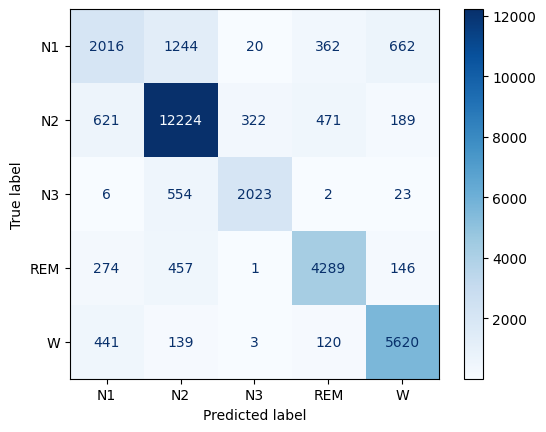

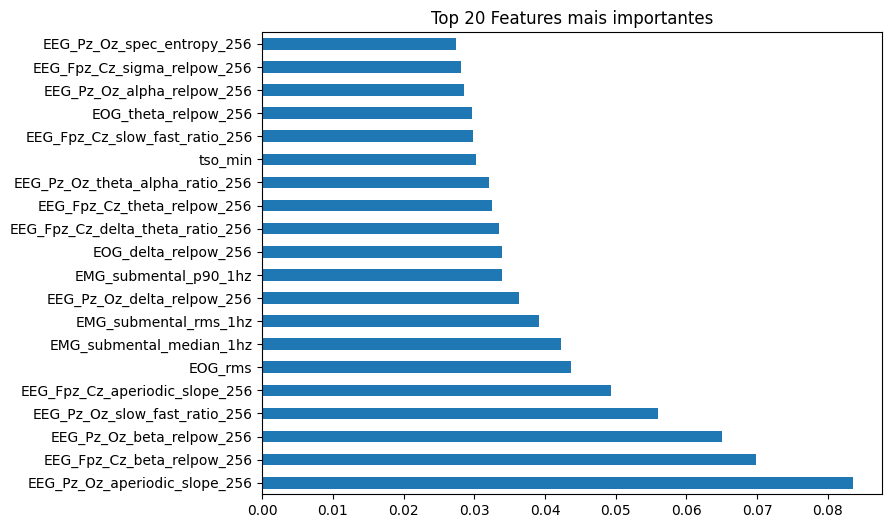

In [7]:
# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.show()

# Importância das features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind="barh", figsize=(8,6))
plt.title("Top 20 Features mais importantes")
plt.show()


6. Otimização de Hiperparâmetros (GridSearch)

In [ ]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced"),
    param_grid,
    cv=3,
    scoring="f1_macro",
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Melhores parâmetros:", grid.best_params_)


#Salvando para uso futuro
output_file = "grid_search_log.txt"

with open(output_file, "w") as f:
    for i, (params, mean, std) in enumerate(zip(
        grid.cv_results_['params'],
        grid.cv_results_['mean_test_score'],
        grid.cv_results_['std_test_score']
    )):
        f.write(f"Fit {i+1}: params={params}, mean_score={mean:.4f}, std={std:.4f}\n")
    
    f.write("\nMelhores parâmetros:\n")
    for key, value in grid.best_params_.items():
        f.write(f"{key}: {value}\n")

print(f"Log completo do GridSearch salvo em '{output_file}'")


8. Modelo Final com Hiperparâmetros Otimizados

In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.60      0.47      0.53      4304
          N2       0.84      0.88      0.86     13827
          N3       0.85      0.78      0.81      2608
         REM       0.82      0.83      0.82      5167
           W       0.85      0.89      0.87      6323

    accuracy                           0.81     32229
   macro avg       0.79      0.77      0.78     32229
weighted avg       0.81      0.81      0.81     32229



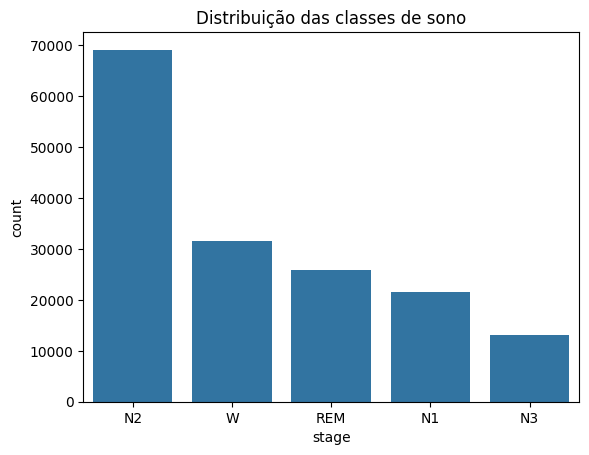

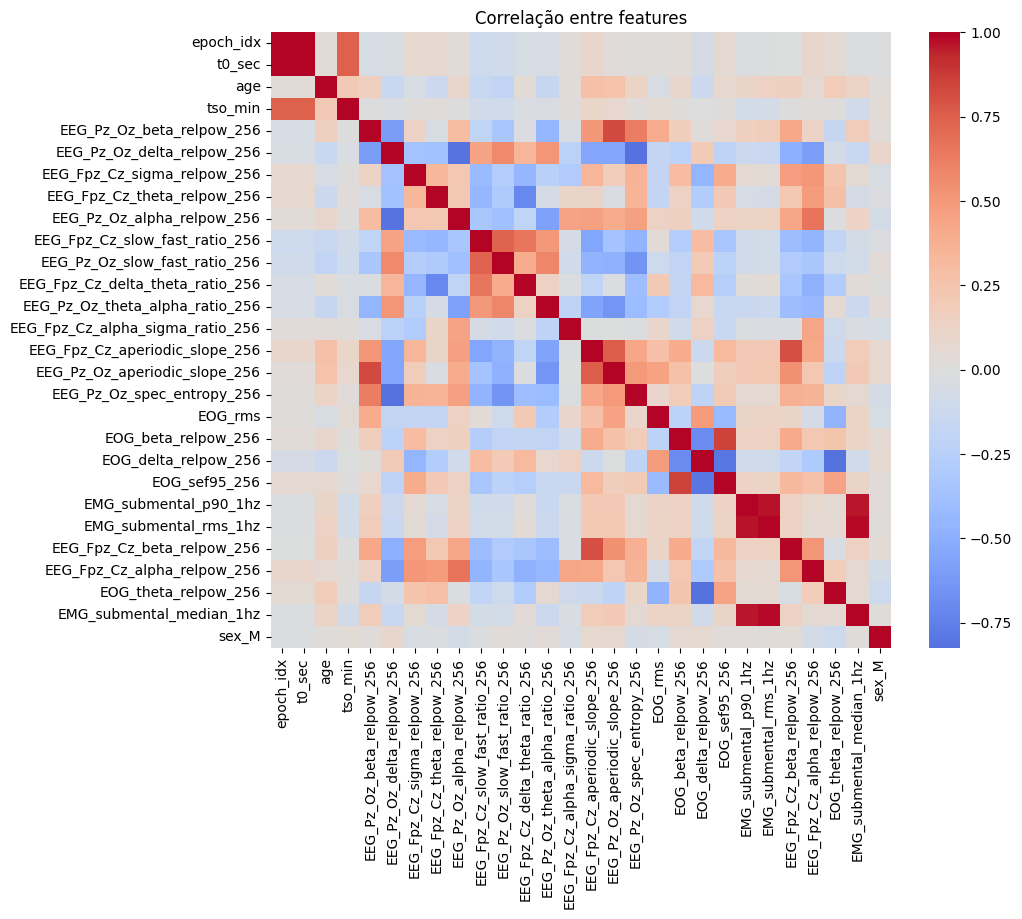

,y_true,y_pred
17308,REM,REM
103929,N2,N2
157741,N2,N2
5726,N2,N2
109013,N2,N2
139616,N1,N2
135323,W,W
149771,W,W
136783,N2,N2
11087,N2,N2


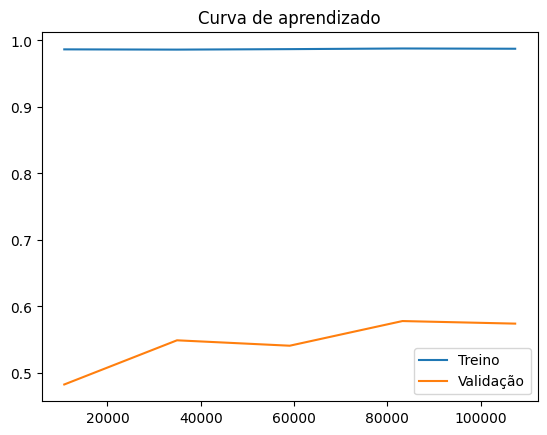

In [10]:
# Balanceamento de classes
sns.countplot(x=y, order=y.value_counts().index)
plt.title("Distribuição das classes de sono")
plt.show()

# Correlação entre features
corr = X.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlação entre features")
plt.show()

# Métricas por classe
erros = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
display(erros.sample(10))

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=3, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Treino")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validação")
plt.legend()
plt.title("Curva de aprendizado")
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SEED = 42

# Remove colunas suspeitas de leakage
cols_drop = [c for c in df_cassette.columns if c.startswith("Event_marker_")]
df_clean = df_cassette.drop(columns=cols_drop, errors="ignore")

# Define target
y = df_clean["stage"]

# Subset de features recomendado
feature_cols = [c for c in df_clean.columns if any(kw in c for kw in [
    "relpow", "ratio", "sef", "entropy", "slope", "median", "rms", "p90"
])]
# Inclui `tso_min` explicitamente
feature_cols += ["tso_min"]

X = df_clean[feature_cols].copy()

# Codifica sexo (binário)
if "sex" in df_clean.columns:
    X = pd.concat([X, pd.get_dummies(df_clean["sex"], prefix="sex", drop_first=True)], axis=1)

# Train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (128912, 25) Teste: (32229, 25)


In [12]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

          N1      0.562     0.434     0.490      4304
          N2      0.827     0.875     0.850     13827
          N3      0.830     0.759     0.793      2608
         REM      0.802     0.810     0.806      5167
           W      0.834     0.879     0.856      6323

    accuracy                          0.797     32229
   macro avg      0.771     0.752     0.759     32229
weighted avg      0.789     0.797     0.792     32229



In [14]:
def subset_and_train(suffix="_256"):
    feat_subset = [c for c in feature_cols if c.endswith(suffix)] + ["tso_min"]
    X_sub = df_clean[feat_subset].copy()
    if "sex" in df_clean.columns:
        X_sub = pd.concat([X_sub, pd.get_dummies(df_clean["sex"], drop_first=True)], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced"
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f"\n===== Resultados para {suffix} =====")
    print(classification_report(y_test, y_pred, digits=3))

# Testa _256 e _512
subset_and_train("_256")
subset_and_train("_512")



===== Resultados para _256 =====
              precision    recall  f1-score   support

          N1      0.531     0.363     0.431      4304
          N2      0.813     0.869     0.840     13827
          N3      0.807     0.737     0.771      2608
         REM      0.741     0.777     0.759      5167
           W      0.817     0.865     0.840      6323

    accuracy                          0.775     32229
   macro avg      0.742     0.722     0.728     32229
weighted avg      0.764     0.775     0.767     32229


===== Resultados para _512 =====
              precision    recall  f1-score   support

          N1      0.189     0.237     0.211      4304
          N2      0.481     0.174     0.256     13827
          N3      0.157     0.535     0.243      2608
         REM      0.210     0.325     0.255      5167
           W      0.423     0.331     0.372      6323

    accuracy                          0.267     32229
   macro avg      0.292     0.321     0.267     32229
weighted 

In [15]:
df_temp = df_clean.copy()
window = 3
for col in feature_cols:
    df_temp[f"{col}_rollmean"] = df_temp[col].rolling(window=window, min_periods=1).mean()

X_temp = df_temp[[c for c in df_temp.columns if any(kw in c for kw in ["relpow", "ratio", "sef", "entropy", "slope", "median", "rms", "p90", "rollmean"])] + ["tso_min"]]

if "sex" in df_temp.columns:
    X_temp = pd.concat([X_temp, pd.get_dummies(df_temp["sex"], drop_first=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=SEED, stratify=y
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Com features temporais (rolling mean):")
print(classification_report(y_test, y_pred, digits=3))


Com features temporais (rolling mean):
              precision    recall  f1-score   support

          N1      0.641     0.509     0.567      4304
          N2      0.848     0.899     0.873     13827
          N3      0.852     0.780     0.814      2608
         REM      0.839     0.850     0.844      5167
           W      0.860     0.889     0.874      6323

    accuracy                          0.827     32229
   macro avg      0.808     0.785     0.794     32229
weighted avg      0.822     0.827     0.823     32229



              precision    recall  f1-score   support

          N1       0.68      0.49      0.57      4304
          N2       0.84      0.91      0.87     13827
          N3       0.87      0.78      0.82      2608
         REM       0.85      0.85      0.85      5167
           W       0.85      0.90      0.87      6323

    accuracy                           0.83     32229
   macro avg       0.82      0.78      0.80     32229
weighted avg       0.83      0.83      0.83     32229



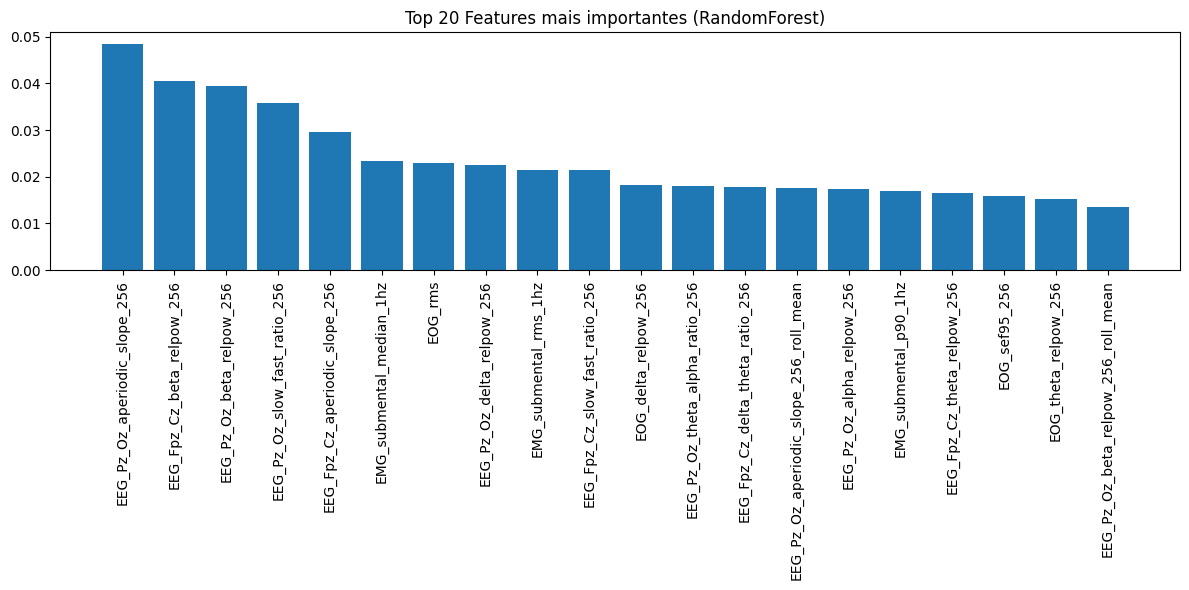

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ======================
# 1. Preparar rolling features (média, std, max) por sujeito
# ======================
def add_rolling_features_sleep(df, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=5):
    df_sorted = df.sort_values(by=[subject_col, epoch_col]).copy()
    
    # Seleciona apenas colunas numéricas (float/int) para rolling
    feature_cols = df_sorted.select_dtypes(include=["float64", "int64"]).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in [epoch_col]]
    
    for col in feature_cols:
        df_sorted[f"{col}_roll_mean"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df_sorted[f"{col}_roll_std"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df_sorted[f"{col}_roll_max"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
        
    return df_sorted

# ======================
# 2. Aplicar rolling no dataset
# ======================
df_rolled = add_rolling_features_sleep(df_cassette, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=5)

# ======================
# 3. Separar features e target
# ======================
# Remove Event_marker_* para evitar leakage
drop_cols = [col for col in df_rolled.columns if "Event_marker" in col]
X = df_rolled.drop(columns=["stage", "subject_id", "epoch_idx"] + drop_cols)
y = df_rolled["stage"]

# Transformar categóricas em dummies antes do split
X = pd.get_dummies(X, drop_first=True)

# Split treino/teste estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======================
# 4. Treinar RandomForest
# ======================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Avaliação
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# ======================
# 5. Feature importance
# ======================
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20

plt.figure(figsize=(12,6))
plt.title("Top 20 Features mais importantes (RandomForest)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()


In [23]:

# ======================
# 1. Preparar rolling features (média, std, max) por sujeito
# ======================
def add_rolling_features_sleep(df, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=5):
    df_sorted = df.sort_values(by=[subject_col, epoch_col]).copy()
    
    # Seleciona apenas colunas numéricas (float/int) para rolling
    feature_cols = df_sorted.select_dtypes(include=["float64", "int64"]).columns.tolist()
    # Remove epoch_col e colunas que não queremos usar
    feature_cols = [col for col in feature_cols if col not in [epoch_col, "age"]]
    
    for col in feature_cols:
        df_sorted[f"{col}_roll_mean"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df_sorted[f"{col}_roll_std"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df_sorted[f"{col}_roll_max"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
        
    return df_sorted

# ======================
# 2. Aplicar rolling no dataset
# ======================
df_rolled = add_rolling_features_sleep(df_cassette, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=5)

# ======================
# 3. Separar features e target (somente numéricas)
# ======================
drop_cols = ["subject_id", "sex", "age"] + [col for col in df_rolled.columns if "Event_marker" in col]
X = df_rolled.drop(columns=["stage", "epoch_idx"] + drop_cols)
y = df_rolled["stage"]

# Seleciona apenas colunas numéricas em X
X = X.select_dtypes(include=["float64", "int64"])

# Split treino/teste estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======================
# 4. Treinar RandomForest
# ======================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Avaliação
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# ======================
# 5. Feature importance em texto
# ======================
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20

top_features = [X.columns[i] for i in indices[:top_n]]
top_importances = [importances[i] for i in indices[:top_n]]

print("Top 20 Features mais importantes (RandomForest):\n")
for rank, (feat, imp) in enumerate(zip(top_features, top_importances), start=1):
    print(f"{rank:02d}. {feat} - {imp:.4f}")


              precision    recall  f1-score   support

          N1       0.66      0.47      0.55      4304
          N2       0.83      0.91      0.87     13827
          N3       0.86      0.77      0.81      2608
         REM       0.85      0.84      0.84      5167
           W       0.85      0.90      0.87      6323

    accuracy                           0.83     32229
   macro avg       0.81      0.78      0.79     32229
weighted avg       0.82      0.83      0.82     32229

Top 20 Features mais importantes (RandomForest):

01. EEG_Pz_Oz_aperiodic_slope_256 - 0.0511
02. EEG_Pz_Oz_beta_relpow_256 - 0.0444
03. EEG_Fpz_Cz_beta_relpow_256 - 0.0419
04. EEG_Pz_Oz_slow_fast_ratio_256 - 0.0371
05. EEG_Fpz_Cz_aperiodic_slope_256 - 0.0273
06. EMG_submental_median_1hz - 0.0238
07. EOG_rms - 0.0235
08. EEG_Pz_Oz_aperiodic_slope_256_roll_mean - 0.0219
09. EEG_Pz_Oz_delta_relpow_256 - 0.0216
10. EMG_submental_rms_1hz - 0.0209
11. EEG_Fpz_Cz_delta_theta_ratio_256 - 0.0202
12. EEG_Pz_Oz_alpha

In [26]:
# ======================
# 1. Função para rolling features
# ======================
def add_rolling_features_sleep(df, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=5):
    df_sorted = df.sort_values(by=[subject_col, epoch_col]).copy()
    
    # Seleciona apenas colunas numéricas (float/int) para rolling
    feature_cols = df_sorted.select_dtypes(include=["float64", "int64"]).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in [epoch_col]]
    
    for col in feature_cols:
        df_sorted[f"{col}_roll_mean_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df_sorted[f"{col}_roll_std_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df_sorted[f"{col}_roll_max_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
        
    return df_sorted

# ======================
# 2. Preparar datasets
# ======================
windows = [20, 50]
results = {}

for w in windows:
    print(f"\n====== Rolling Window: {w} epochs ======\n")
    
    df_rolled = add_rolling_features_sleep(df_cassette, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=w)
    
    # Drop colunas desnecessárias
    X = df_rolled.drop(columns=["stage", "subject_id", "epoch_idx", "sex", "age"], errors="ignore")

    # Seleciona apenas colunas numéricas (float/int)
    X = X.select_dtypes(include=["float64", "int64"])

    y = df_rolled["stage"]
    
    # Split treino/teste estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # ======================
    # 3. Treinar RandomForest
    # ======================
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    )
    rf.fit(X_train, y_train)
    
    # ======================
    # 4. Avaliação
    # ======================
    y_pred = rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[w] = report
    
    print(classification_report(y_test, y_pred))

# ======================
# 5. Comparação resumida por janela
# ======================
for w in windows:
    print(f"\n===== Resumo Rolling {w} epochs =====")
    print("Accuracy:", results[w]['accuracy'])
    print("Macro F1:", results[w]['macro avg']['f1-score'])
    print("Weighted F1:", results[w]['weighted avg']['f1-score'])



====== Rolling Window: 20 epochs ======

              precision    recall  f1-score   support

          N1       0.74      0.56      0.64      4304
          N2       0.86      0.92      0.89     13827
          N3       0.88      0.80      0.84      2608
         REM       0.88      0.89      0.89      5167
           W       0.87      0.90      0.89      6323

    accuracy                           0.86     32229
   macro avg       0.85      0.81      0.83     32229
weighted avg       0.85      0.86      0.85     32229


====== Rolling Window: 50 epochs ======

              precision    recall  f1-score   support

          N1       0.75      0.59      0.66      4304
          N2       0.87      0.92      0.89     13827
          N3       0.88      0.80      0.84      2608
         REM       0.89      0.90      0.89      5167
           W       0.87      0.91      0.89      6323

    accuracy                           0.86     32229
   macro avg       0.85      0.82      0.84    

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# ======================
# 1. Função rolling features
# ======================
def add_rolling_features_sleep(df, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=20):
    df_sorted = df.sort_values(by=[subject_col, epoch_col]).copy()
    
    # Seleciona apenas colunas numéricas para rolling
    feature_cols = df_sorted.select_dtypes(include=["float64", "int64"]).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in [epoch_col]]
    
    for col in feature_cols:
        df_sorted[f"{col}_roll_mean_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df_sorted[f"{col}_roll_std_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df_sorted[f"{col}_roll_max_{window}"] = df_sorted.groupby(subject_col)[col].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
        
    return df_sorted

# ======================
# 2. Preparar dataset com rolling 20
# ======================
df_rolled = add_rolling_features_sleep(df_cassette, subject_col="subject_id", epoch_col="epoch_idx", target_col="stage", window=20)

# Drop colunas não numéricas
X_smote = df_rolled.drop(columns=["stage", "subject_id", "sex", "age", "epoch_idx"], errors="ignore")

# Garantir que todas as features sejam numéricas
X_smote = pd.get_dummies(X_smote, drop_first=True)

X_smote = X_smote.fillna(0)

y = df_rolled["stage"]

# ======================
# 3. Aplicar SMOTE
# ======================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_smote, y)

print("Distribuição antes do SMOTE:\n", y.value_counts())
print("Distribuição após SMOTE:\n", pd.Series(y_res).value_counts())

# ======================
# 4. Split treino/teste
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# ======================
# 5. Treinar RandomForest
# ======================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# ======================
# 6. Avaliação
# ======================
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# ======================
# 7. Top 20 Features mais importantes
# ======================
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20

print("\nTop 20 Features mais importantes (RandomForest + SMOTE + 20 epochs):\n")
for i in range(top_n):
    print(f"{i+1:02d}. {X_smote.columns[indices[i]]} - {importances[indices[i]]:.4f}")


Distribuição antes do SMOTE:
 stage
N2     69132
W      31613
REM    25835
N1     21522
N3     13039
Name: count, dtype: int64
Distribuição após SMOTE:
 stage
W      69132
N1     69132
N2     69132
N3     69132
REM    69132
Name: count, dtype: int64
              precision    recall  f1-score   support

          N1       0.88      0.89      0.88     13827
          N2       0.91      0.86      0.88     13826
          N3       0.95      0.98      0.96     13826
         REM       0.94      0.96      0.95     13827
           W       0.94      0.94      0.94     13826

    accuracy                           0.92     69132
   macro avg       0.92      0.92      0.92     69132
weighted avg       0.92      0.92      0.92     69132


Top 20 Features mais importantes (RandomForest + SMOTE + 20 epochs):

01. EEG_Fpz_Cz_beta_relpow_256 - 0.0509
02. EEG_Pz_Oz_aperiodic_slope_256 - 0.0507
03. EEG_Pz_Oz_beta_relpow_256 - 0.0420
04. EEG_Pz_Oz_slow_fast_ratio_256 - 0.0393
05. EEG_Fpz_Cz_aperiodic_